In [1]:
%run ../utils.py
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
from codex import io as codex_io
from codex import config as codex_config
from skimage import exposure

init_session()

Using TensorFlow backend.


In [51]:
# exp_name = '7-7-17-multicycle'
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 2
# mem_ch = 1
# best_z = 4
# crop = [slice(0, 512), slice(0, 512)]
# tile_file = 'reg001_X01_Y01.tif'

# exp_name = '20180607_D21_activated_Tcells'
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01', 'processor', 'tile')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# best_z = 14
# crop = [slice(None, None), slice(None, None)]
# tile_file = 'R001_X001_Y001.tif'

# exp_name = '20180614_D22_RepA_Tcell_CD4-CD8-DAPI_5by5'
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01', 'processor', 'tile')
# nuc_cyc = 0
# nuc_ch = 0
# best_z = 19
# crop = [slice(None, None), slice(None, None)]
# tile_file = 'R001_X002_Y002.tif'

# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)

exp_name = 'RS002_CODEX_Tonsil_180426'
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'wherrylab', exp_name, '2018_08_02_RS002_processed_cytokit', 'output', 'v01', 'processor', 'tile')
exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', 'wherrylab', exp_name)
nuc_cyc = 0
nuc_ch = 0
best_z = 5
crop = [slice(None, None), slice(None, None)]
tile_file = 'R001_X001_Y001.tif'


In [52]:
exp_conf = codex_config.load(exp_conf_dir)
tile = codex_io.read_tile(osp.join(exp_data_dir, tile_file), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]

if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

tile.shape, tile.dtype

((8, 11, 4, 1905, 1905), dtype('uint8'))

In [53]:
img_nuc = tile[nuc_cyc, best_z, nuc_ch]
img_nuc.shape

(1905, 1905)

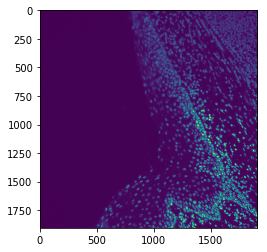

In [54]:
plt.imshow(img_nuc)

In [11]:
# import imp
# imp.reload(cytometer)

In [55]:
def get_next_highest_num_divisible_by_two(n, p=6):
    d = 2 ** p
    while True:
        if n % d == 0:
            return n
        n += 1
get_next_highest_num_divisible_by_two(1344)

1344

In [56]:
%%time
from codex.cytometry import cytometer
cytom = cytometer.Cytometer2D(img_nuc.shape + (1,), target_shape=(1344, 1344)).initialize()
#cytom = cytometer.Cytometer2D(img_nuc.shape + (1,)).initialize()

CPU times: user 2.91 s, sys: 204 ms, total: 3.11 s
Wall time: 3.06 s


In [57]:
%%time
img_seg, img_pred, img_bin = cytom.segment(img_nuc, return_masks=True, min_size=12, nucleus_dilation=8)

CPU times: user 5.68 s, sys: 1.11 s, total: 6.79 s
Wall time: 6.78 s


In [58]:
img_seg.shape, img_pred.shape, img_bin.shape

((1, 2, 1905, 1905), (1, 1905, 1905, 3), (1, 3, 1905, 1905))

In [59]:
from scipy.stats import describe
describe(img_pred[0].ravel())

DescribeResult(nobs=10887075, minmax=(0.0, 1.0), mean=0.33263378679606714, variance=0.19715478318513738, skewness=0.7091341500008785, kurtosis=-1.4054146106451888)

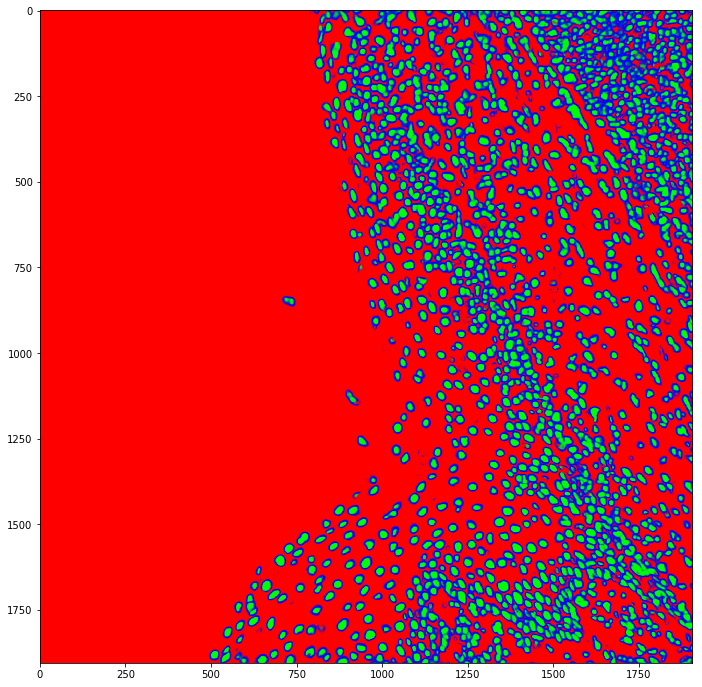

In [60]:
plt.imshow(img_pred[0])
plt.gcf().set_size_inches(12, 12)

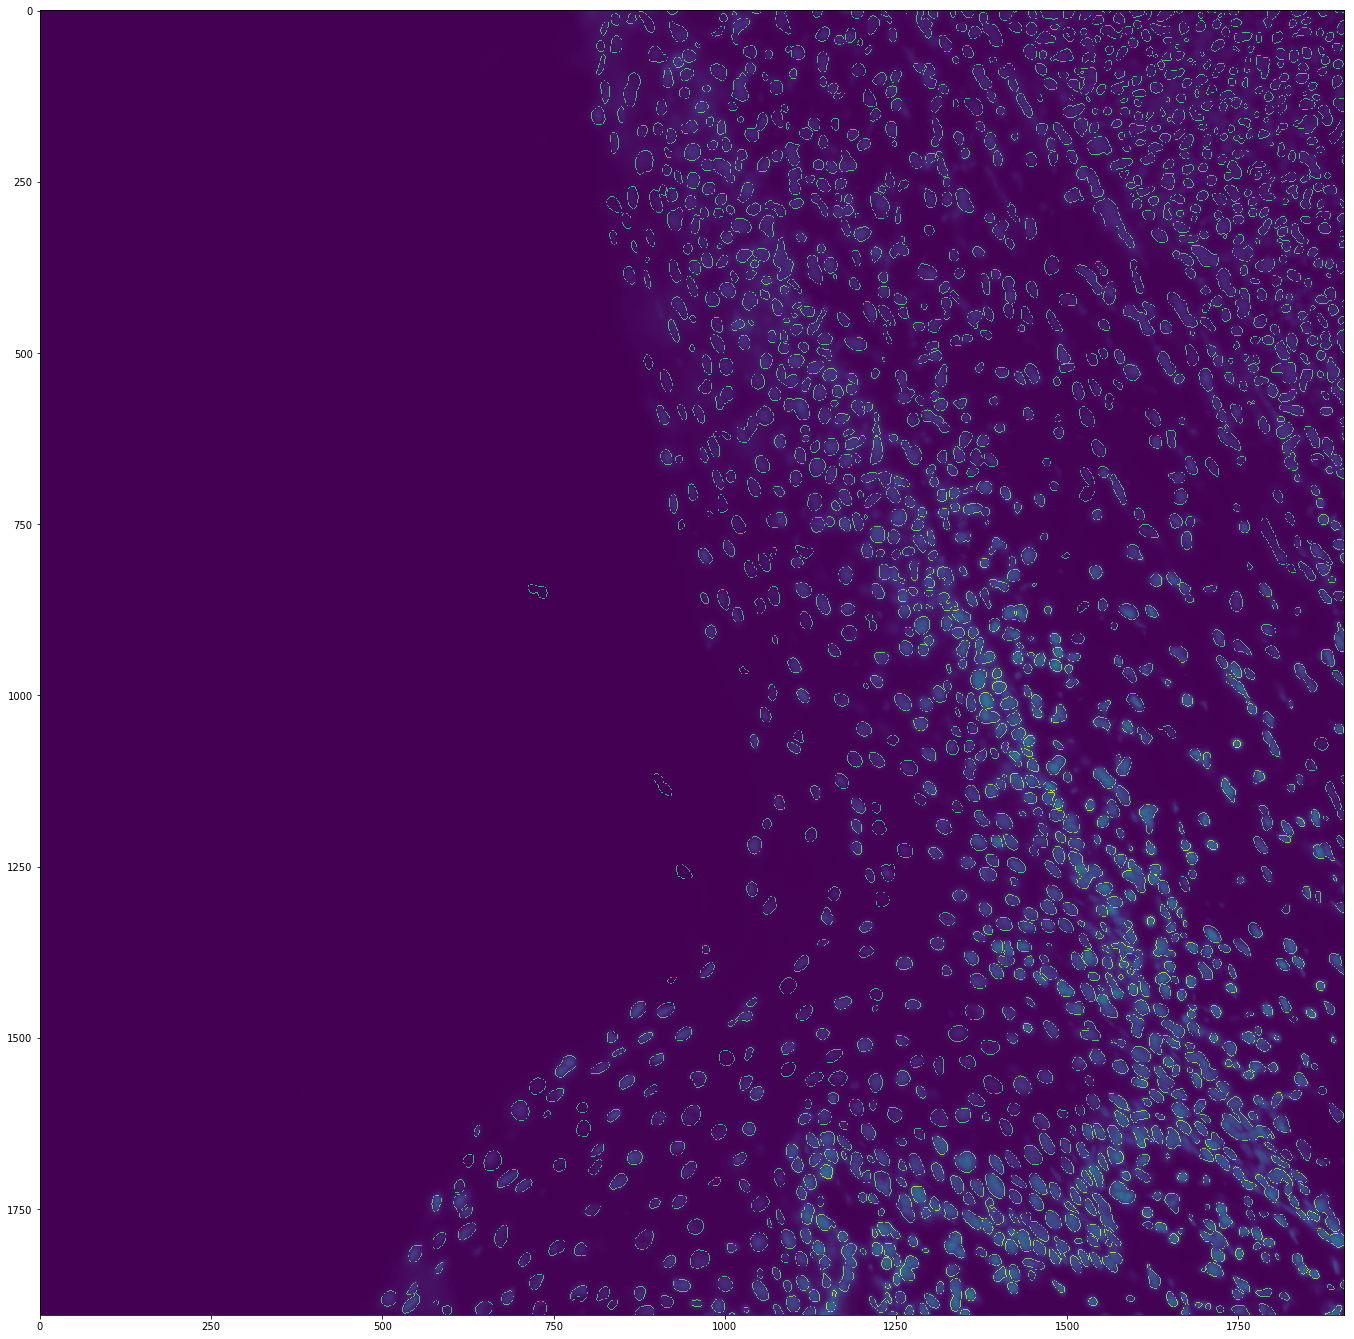

In [62]:
from skimage import segmentation
img_bound = segmentation.find_boundaries(img_seg[0, 1], mode='inner', background=0)
plt.imshow(.5*img_bound.astype(np.uint8) * 255 + .5*img_nuc)
plt.gcf().set_size_inches(24, 24)

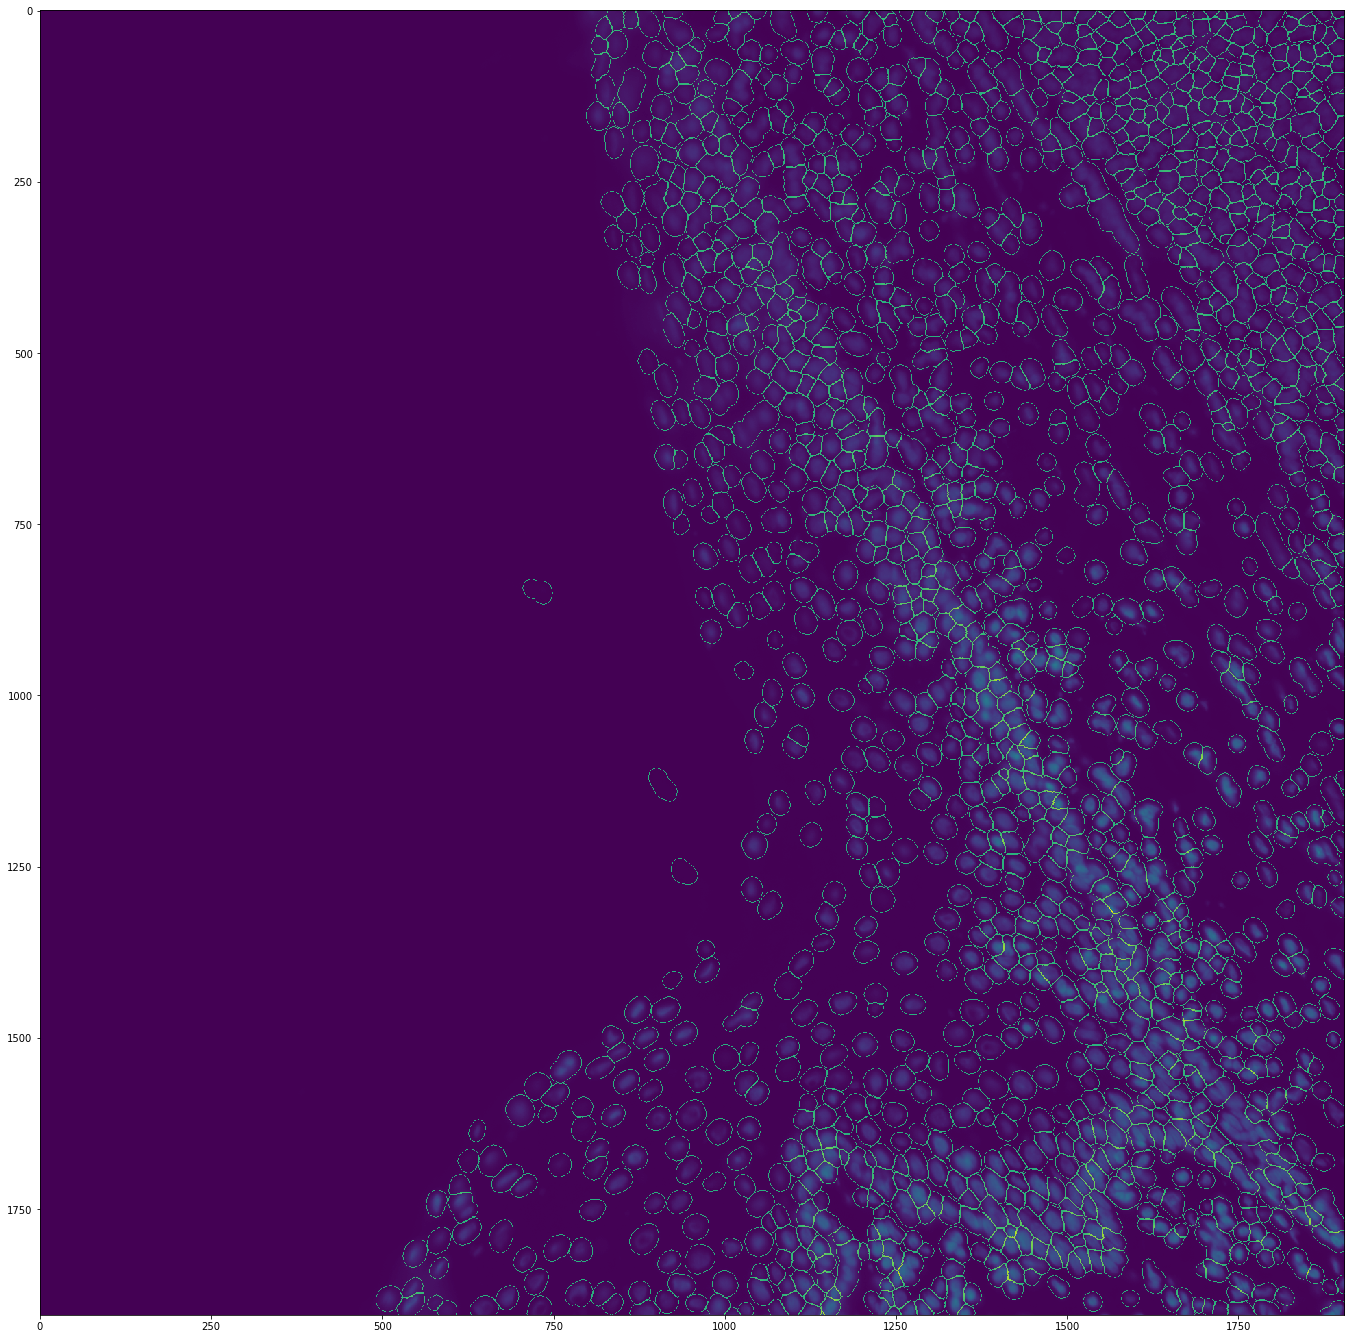

In [63]:
from skimage import segmentation
img_bound = segmentation.find_boundaries(img_seg[0, 0], mode='inner', background=0)
plt.imshow(.5*img_bound.astype(np.uint8) * 255 + .5*img_nuc)
plt.gcf().set_size_inches(24, 24)

In [37]:
# sns.heatmap(img_seg[0, 1, 300:325, 70:125], annot=True, fmt='d')
# plt.gcf().set_size_inches(24, 24)

In [38]:
# from skimage import segmentation
# img_bound = segmentation.find_boundaries(img_seg[0, 0], mode='inner', background=0)
# img_plt = .5*img_bound.astype(np.uint8) * 255 + .5*img_nuc
# #plt.imshow(img_seg[0, 1, 300:350, 50:150])
# plt.imshow(img_seg[0, 1, 300:350, 50:150].clip(400, 500), cmap='Spectral')
# plt.gcf().set_size_inches(24, 24)